In [1]:
import json 
import pandas as pd 
from pandasql import sqldf
import string
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt
import datetime as dt
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split 

# 1. data cleaning

In [3]:
with open('US_category_id.json') as f:
    cat_data = json.load(f)
    ID = [int(x.get('id')) for x in cat_data.get('items')]
    category = [x.get('snippet').get('title')for x in cat_data.get('items')]
    category_id_dict = dict(zip(ID, category))
    #print(category_id_dict)
    
vid_data_df = pd.read_csv('USvideos.csv', parse_dates = ['publish_time'])
vid_data_df['category_name'] = vid_data_df['category_id'].map(category_id_dict)
vid_data_df = vid_data_df.drop(['thumbnail_link', 'comments_disabled', 'ratings_disabled', 'video_error_or_removed'],axis=1)
vid_data_df['trending_date'] = vid_data_df['trending_date'].apply(lambda x: dt.datetime.strptime(x,'%y.%d.%m'))
vid_data_df['trending_date'] = vid_data_df['trending_date'].apply(lambda x:x.date())
vid_data_df['publish_time'] = vid_data_df['publish_time'].apply(lambda x:x.date())

In [4]:
vid_data_df.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,description,category_name
0,2kyS6SvSYSE,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13,SHANtell martin,748374,57527,2966,15954,SHANTELL'S CHANNEL - https://www.youtube.com/s...,People & Blogs
1,1ZAPwfrtAFY,2017-11-14,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,"One year after the presidential election, John...",Entertainment
2,5qpjK5DgCt4,2017-11-14,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,Comedy
3,puqaWrEC7tY,2017-11-14,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,Today we find out if Link is a Nickelback amat...,Entertainment
4,d380meD0W0M,2017-11-14,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,I know it's been a while since we did this sho...,Entertainment


# 2. Explorative data analysis

In [5]:
trend=vid_data_df.groupby('trending_date').mean()

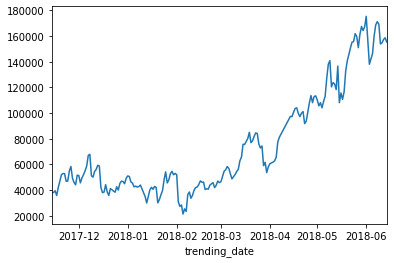

In [6]:
trend['likes'].plot()

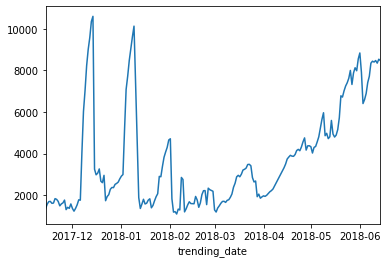

In [7]:
trend['dislikes'].plot()

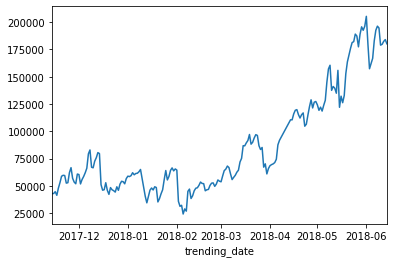

In [8]:
(trend['likes']+trend['dislikes']+trend['comment_count']).plot()

In [9]:
vid_data_df["trend-publish"]=(vid_data_df["trending_date"]-vid_data_df["publish_time"]).apply(lambda x:x.days)

In [10]:
diff=vid_data_df.groupby('trend-publish').mean()

(array([ 0., 10., 20., 30., 40., 50.]), <a list of 6 Text xticklabel objects>)

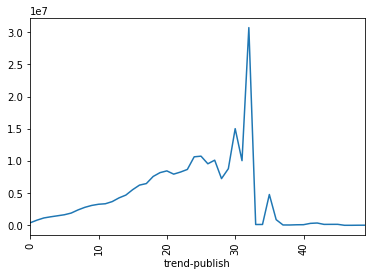

In [11]:
diff["views"].iloc[0:50].plot()
plt.xticks(rotation=90)

In [12]:
vid_data_df.dtypes

video_id         object
trending_date    object
title            object
channel_title    object
category_id       int64
publish_time     object
tags             object
views             int64
likes             int64
dislikes          int64
comment_count     int64
description      object
category_name    object
trend-publish     int64
dtype: object

In [13]:
sqldf("SELECT COUNT(*), category_name FROM vid_data_df group by category_id;", locals())

,COUNT(*),category_name
0,2345,Film & Animation
1,384,Autos & Vehicles
2,6472,Music
3,920,Pets & Animals
4,2174,Sports
5,402,Travel & Events
6,817,Gaming
7,3210,People & Blogs
8,3457,Comedy
9,9964,Entertainment


In [14]:
#video views top 10 
df_viewa_top10=sqldf("SELECT max(views),video_id, title, category_name FROM vid_data_df group by video_id order by max(views) DESC limit 10;", locals())
df_viewa_top10

,max(views),video_id,title,category_name
0,225211923,VYOjWnS4cMY,Childish Gambino - This Is America (Official V...,Music
1,149376127,FlsCjmMhFmw,YouTube Rewind: The Shape of 2017 | #YouTubeRe...,Entertainment
2,148689896,ffxKSjUwKdU,Ariana Grande - No Tears Left To Cry,Music
3,139334502,zEf423kYfqk,"Becky G, Natti Natasha - Sin Pijama (Official ...",Music
4,123010920,7C2z4GqqS5E,BTS (방탄소년단) 'FAKE LOVE' Official MV,Music
5,122544931,M4ZoCHID9GI,The Weeknd - Call Out My Name (Official Video),Music
6,102012605,TyHvyGVs42U,"Luis Fonsi, Demi Lovato - Échame La Culpa",Music
7,94254507,xTlNMmZKwpA,"Cardi B, Bad Bunny & J Balvin - I Like It [Off...",Music
8,91933007,6ZfuNTqbHE8,Marvel Studios' Avengers: Infinity War Officia...,Entertainment
9,87264467,-BQJo3vK8O8,Maluma - El Préstamo (Official Video),Music


In [15]:
#video likes top 10
df_likes_top10=sqldf("SELECT max(likes),video_id, title,category_name FROM vid_data_df group by video_id order by max(likes) DESC limit 10;", locals())
df_likes_top10

,max(likes),video_id,title,category_name
0,5613827,7C2z4GqqS5E,BTS (방탄소년단) 'FAKE LOVE' Official MV,Music
1,5023450,VYOjWnS4cMY,Childish Gambino - This Is America (Official V...,Music
2,3094021,ffxKSjUwKdU,Ariana Grande - No Tears Left To Cry,Music
3,3093544,FlsCjmMhFmw,YouTube Rewind: The Shape of 2017 | #YouTubeRe...,Entertainment
4,2729292,kTlv5_Bs8aw,BTS (방탄소년단) 'MIC Drop (Steve Aoki Remix)' Offi...,Music
5,2700800,p8npDG2ulKQ,BTS (방탄소년단) LOVE YOURSELF 轉 Tear 'Singularity'...,Music
6,2672431,OK3GJ0WIQ8s,j-hope 'Daydream (백일몽)' MV,Music
7,2625661,6ZfuNTqbHE8,Marvel Studios' Avengers: Infinity War Officia...,Entertainment
8,2488565,aJOTlE1K90k,Maroon 5 - Girls Like You ft. Cardi B,Music
9,2376636,TyHvyGVs42U,"Luis Fonsi, Demi Lovato - Échame La Culpa",Music


In [16]:
#category views top 10
sqldf("select sum(max_views),category_name, category_id from \
(SELECT max(views) as max_views,category_id,category_name FROM vid_data_df group by video_id order by max(views) DESC)\
group by category_id order by sum(max_views) desc;")

,sum(max_views),category_name,category_id
0,4828186880,Music,10
1,2828466347,Entertainment,24
2,825269649,Film & Animation,1
3,773873112,Comedy,23
4,667660862,People & Blogs,22
5,639466822,Sports,17
6,557056875,Howto & Style,26
7,428563438,Science & Technology,28
8,239483937,Gaming,20
9,231807005,News & Politics,25


In [17]:
#category likes top 10
sqldf("select sum(max_likes),category_name, category_id from \
(SELECT max(likes) as max_likes,category_id,category_name FROM vid_data_df group by video_id order by max(likes) DESC)\
group by category_id order by sum(max_likes) desc;")

,sum(max_likes),category_name,category_id
0,150651038,Music,10
1,67442642,Entertainment,24
2,29960684,Comedy,23
3,23006906,People & Blogs,22
4,20646383,Howto & Style,26
5,17044196,Film & Animation,1
6,12584133,Sports,17
7,10165998,Science & Technology,28
8,6991366,Gaming,20
9,5402061,Education,27


In [18]:
#channel views top 10
sqldf("SELECT max(views),channel_title FROM vid_data_df group by channel_title order by max(views) DESC limit 10;", locals())

,max(views),channel_title
0,225211923,ChildishGambinoVEVO
1,149376127,YouTube Spotlight
2,148689896,ArianaGrandeVevo
3,139334502,BeckyGVEVO
4,123010920,ibighit
5,122544931,TheWeekndVEVO
6,102012605,LuisFonsiVEVO
7,94254507,Cardi B
8,91933007,Marvel Entertainment
9,87264467,MalumaVEVO


In [19]:
#channel likes top 10
sqldf("SELECT max(likes),channel_title FROM vid_data_df group by channel_title order by max(likes) DESC limit 10;", locals())

,max(likes),channel_title
0,5613827,ibighit
1,5023450,ChildishGambinoVEVO
2,3094021,ArianaGrandeVevo
3,3093544,YouTube Spotlight
4,2625661,Marvel Entertainment
5,2488565,Maroon5VEVO
6,2376636,LuisFonsiVEVO
7,2032463,David Dobrik
8,1988746,Logan Paul Vlogs
9,1928392,TaylorSwiftVEVO


# Likes vs. The lenghth of trending period

In [20]:
df_like_trending_period=sqldf("SELECT video_id,title,category_name, max(trending_date),min(trending_date),max(likes) FROM vid_data_df group by video_id order by max(likes) DESC limit 100;", locals())
df_like_trending_period

,video_id,title,category_name,max(trending_date),min(trending_date),max(likes)
0,7C2z4GqqS5E,BTS (방탄소년단) 'FAKE LOVE' Official MV,Music,2018-06-01,2018-05-19,5613827
1,VYOjWnS4cMY,Childish Gambino - This Is America (Official V...,Music,2018-06-02,2018-05-08,5023450
2,ffxKSjUwKdU,Ariana Grande - No Tears Left To Cry,Music,2018-05-14,2018-04-21,3094021
3,FlsCjmMhFmw,YouTube Rewind: The Shape of 2017 | #YouTubeRe...,Entertainment,2017-12-14,2017-12-07,3093544
4,kTlv5_Bs8aw,BTS (방탄소년단) 'MIC Drop (Steve Aoki Remix)' Offi...,Music,2017-12-01,2017-11-25,2729292
...,...,...,...,...,...,...
95,vn9mMeWcgoM,Jurassic World: Fallen Kingdom - Official Trai...,Entertainment,2017-12-15,2017-12-09,550348
96,d1D1SJ-KqaQ,WINNER - ‘EVERYDAY’ M/V,Music,2018-04-21,2018-04-06,548563
97,9v_rtaye2yY,"Migos, Nicki Minaj, Cardi B - MotorSport (Offi...",Music,2017-12-15,2017-12-09,548457
98,GEB2f5dpFXs,THRIFTING BRANDS!! GOODWILL WITH GREATLIZA.,Comedy,2018-01-03,2017-12-22,527481


In [21]:
date_format = "%Y-%m-%d"
df_like_trending_period['max(trending_date)']=df_like_trending_period['max(trending_date)'].apply(lambda x:dt.datetime.strptime(x, date_format))
df_like_trending_period['min(trending_date)']=df_like_trending_period['min(trending_date)'].apply(lambda x:dt.datetime.strptime(x, date_format))
df_like_trending_period['trending_period']=df_like_trending_period['max(trending_date)']-df_like_trending_period['min(trending_date)']
df_like_trending_period['trending_period']=df_like_trending_period['trending_period'].apply(lambda x:x.days)
df_like_trending_period

,video_id,title,category_name,max(trending_date),min(trending_date),max(likes),trending_period
0,7C2z4GqqS5E,BTS (방탄소년단) 'FAKE LOVE' Official MV,Music,2018-06-01,2018-05-19,5613827,13
1,VYOjWnS4cMY,Childish Gambino - This Is America (Official V...,Music,2018-06-02,2018-05-08,5023450,25
2,ffxKSjUwKdU,Ariana Grande - No Tears Left To Cry,Music,2018-05-14,2018-04-21,3094021,23
3,FlsCjmMhFmw,YouTube Rewind: The Shape of 2017 | #YouTubeRe...,Entertainment,2017-12-14,2017-12-07,3093544,7
4,kTlv5_Bs8aw,BTS (방탄소년단) 'MIC Drop (Steve Aoki Remix)' Offi...,Music,2017-12-01,2017-11-25,2729292,6
...,...,...,...,...,...,...,...
95,vn9mMeWcgoM,Jurassic World: Fallen Kingdom - Official Trai...,Entertainment,2017-12-15,2017-12-09,550348,6
96,d1D1SJ-KqaQ,WINNER - ‘EVERYDAY’ M/V,Music,2018-04-21,2018-04-06,548563,15
97,9v_rtaye2yY,"Migos, Nicki Minaj, Cardi B - MotorSport (Offi...",Music,2017-12-15,2017-12-09,548457,6
98,GEB2f5dpFXs,THRIFTING BRANDS!! GOODWILL WITH GREATLIZA.,Comedy,2018-01-03,2017-12-22,527481,12


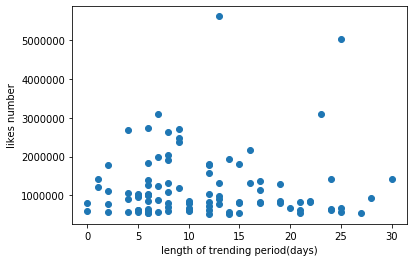

In [22]:
x=df_like_trending_period['trending_period']
y=df_like_trending_period['max(likes)']
plt.scatter(x,y)
plt.xlabel("length of trending period(days)")
plt.ylabel("likes number")
plt.show()

In [23]:
X=df_like_trending_period['trending_period'].values.reshape(-1,1)
y=df_like_trending_period['max(likes)'].values.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# Create linear regression object
regr = linear_model.LinearRegression()
# Train the model using the training sets
regr.fit(X_train, y_train)
# Make predictions using the testing set
y_pred = regr.predict(X_test)
# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

Coefficients: 
 [[4808.53341848]]
Mean squared error: 560392010191.19
Coefficient of determination: -0.01


In [24]:
#Conclusion
#r2_score is negative and the model is arbitrarily worse. There is no linear regression
#between likes number and the length of trending period

# Views vs. length of trending period

In [25]:
df_views_trending_period=sqldf("SELECT video_id,title, category_name,max(trending_date),min(trending_date),max(views) FROM vid_data_df group by video_id order by max(views) DESC limit 100;", locals())
df_views_trending_period

,video_id,title,category_name,max(trending_date),min(trending_date),max(views)
0,VYOjWnS4cMY,Childish Gambino - This Is America (Official V...,Music,2018-06-02,2018-05-08,225211923
1,FlsCjmMhFmw,YouTube Rewind: The Shape of 2017 | #YouTubeRe...,Entertainment,2017-12-14,2017-12-07,149376127
2,ffxKSjUwKdU,Ariana Grande - No Tears Left To Cry,Music,2018-05-14,2018-04-21,148689896
3,zEf423kYfqk,"Becky G, Natti Natasha - Sin Pijama (Official ...",Music,2018-05-15,2018-04-21,139334502
4,7C2z4GqqS5E,BTS (방탄소년단) 'FAKE LOVE' Official MV,Music,2018-06-01,2018-05-19,123010920
...,...,...,...,...,...,...
95,Zr4md5OqL60,Bud Light - The Bud Knight,Entertainment,2018-02-09,2018-02-03,19669098
96,XUqRem0W8L8,Drake - God's Plan (Official Music Video),Music,2018-02-27,2018-02-17,19586636
97,xZNBFcwd7zc,"Deadpool, Meet Cable",Film & Animation,2018-02-17,2018-02-08,19434177
98,MuPL-PSMX0Q,World's Longest LEGO Walk | Dude Perfect,Sports,2018-03-14,2018-03-06,19412787


In [26]:
date_format = "%Y-%m-%d"
df_views_trending_period['max(trending_date)']=df_views_trending_period['max(trending_date)'].apply(lambda x:dt.datetime.strptime(x, date_format))
df_views_trending_period['min(trending_date)']=df_views_trending_period['min(trending_date)'].apply(lambda x:dt.datetime.strptime(x, date_format))
df_views_trending_period['trending_period']=df_views_trending_period['max(trending_date)']-df_views_trending_period['min(trending_date)']
df_views_trending_period['trending_period']=df_views_trending_period['trending_period'].apply(lambda x:x.days)
df_views_trending_period

,video_id,title,category_name,max(trending_date),min(trending_date),max(views),trending_period
0,VYOjWnS4cMY,Childish Gambino - This Is America (Official V...,Music,2018-06-02,2018-05-08,225211923,25
1,FlsCjmMhFmw,YouTube Rewind: The Shape of 2017 | #YouTubeRe...,Entertainment,2017-12-14,2017-12-07,149376127,7
2,ffxKSjUwKdU,Ariana Grande - No Tears Left To Cry,Music,2018-05-14,2018-04-21,148689896,23
3,zEf423kYfqk,"Becky G, Natti Natasha - Sin Pijama (Official ...",Music,2018-05-15,2018-04-21,139334502,24
4,7C2z4GqqS5E,BTS (방탄소년단) 'FAKE LOVE' Official MV,Music,2018-06-01,2018-05-19,123010920,13
...,...,...,...,...,...,...,...
95,Zr4md5OqL60,Bud Light - The Bud Knight,Entertainment,2018-02-09,2018-02-03,19669098,6
96,XUqRem0W8L8,Drake - God's Plan (Official Music Video),Music,2018-02-27,2018-02-17,19586636,10
97,xZNBFcwd7zc,"Deadpool, Meet Cable",Film & Animation,2018-02-17,2018-02-08,19434177,9
98,MuPL-PSMX0Q,World's Longest LEGO Walk | Dude Perfect,Sports,2018-03-14,2018-03-06,19412787,8


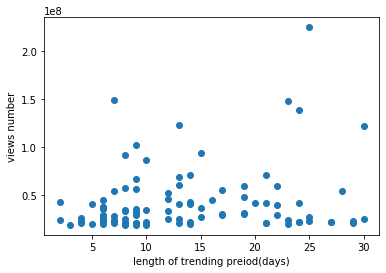

In [27]:
x=df_views_trending_period['trending_period']
y=df_views_trending_period['max(views)']
plt.scatter(x,y)
plt.xlabel("length of trending preiod(days)")
plt.ylabel("views number")
plt.show()

In [28]:
X=df_views_trending_period['trending_period'].values.reshape(-1,1)
y=df_views_trending_period['max(views)'].values.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# Create linear regression object
regr = linear_model.LinearRegression()
# Train the model using the training sets
regr.fit(X_train, y_train)
# Make predictions using the testing set
y_pred = regr.predict(X_test)
# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

Coefficients: 
 [[977632.95069663]]
Mean squared error: 1044996744737327.75
Coefficient of determination: 0.00


In [29]:
#Conclusion
#There is no linear regression between views number and the length of trending period

# Views vs. Days btw publish and first trending date

In [30]:
df_views_time_lag=sqldf("SELECT video_id,title,min(trending_date),publish_time,max(views) FROM vid_data_df group by video_id order by max(views) DESC limit 100;", locals())
df_views_time_lag

,video_id,title,min(trending_date),publish_time,max(views)
0,VYOjWnS4cMY,Childish Gambino - This Is America (Official V...,2018-05-08,2018-05-06,225211923
1,FlsCjmMhFmw,YouTube Rewind: The Shape of 2017 | #YouTubeRe...,2017-12-07,2017-12-06,149376127
2,ffxKSjUwKdU,Ariana Grande - No Tears Left To Cry,2018-04-21,2018-04-20,148689896
3,zEf423kYfqk,"Becky G, Natti Natasha - Sin Pijama (Official ...",2018-04-21,2018-04-20,139334502
4,7C2z4GqqS5E,BTS (방탄소년단) 'FAKE LOVE' Official MV,2018-05-19,2018-05-18,123010920
...,...,...,...,...,...
95,Zr4md5OqL60,Bud Light - The Bud Knight,2018-02-03,2018-02-01,19669098
96,XUqRem0W8L8,Drake - God's Plan (Official Music Video),2018-02-17,2018-02-16,19586636
97,xZNBFcwd7zc,"Deadpool, Meet Cable",2018-02-08,2018-02-07,19434177
98,MuPL-PSMX0Q,World's Longest LEGO Walk | Dude Perfect,2018-03-06,2018-03-05,19412787


In [31]:
date_format = "%Y-%m-%d"
df_views_time_lag['min(trending_date)']=df_views_time_lag['min(trending_date)'].apply(lambda x:dt.datetime.strptime(x, date_format))
df_views_time_lag['publish_time']=df_views_time_lag['publish_time'].apply(lambda x:dt.datetime.strptime(x, date_format))
df_views_time_lag['time_lag']=df_views_time_lag['min(trending_date)']-df_views_time_lag['publish_time']
df_views_time_lag['time_lag']=df_views_time_lag['time_lag'].apply(lambda x:x.days)
df_views_time_lag

,video_id,title,min(trending_date),publish_time,max(views),time_lag
0,VYOjWnS4cMY,Childish Gambino - This Is America (Official V...,2018-05-08,2018-05-06,225211923,2
1,FlsCjmMhFmw,YouTube Rewind: The Shape of 2017 | #YouTubeRe...,2017-12-07,2017-12-06,149376127,1
2,ffxKSjUwKdU,Ariana Grande - No Tears Left To Cry,2018-04-21,2018-04-20,148689896,1
3,zEf423kYfqk,"Becky G, Natti Natasha - Sin Pijama (Official ...",2018-04-21,2018-04-20,139334502,1
4,7C2z4GqqS5E,BTS (방탄소년단) 'FAKE LOVE' Official MV,2018-05-19,2018-05-18,123010920,1
...,...,...,...,...,...,...
95,Zr4md5OqL60,Bud Light - The Bud Knight,2018-02-03,2018-02-01,19669098,2
96,XUqRem0W8L8,Drake - God's Plan (Official Music Video),2018-02-17,2018-02-16,19586636,1
97,xZNBFcwd7zc,"Deadpool, Meet Cable",2018-02-08,2018-02-07,19434177,1
98,MuPL-PSMX0Q,World's Longest LEGO Walk | Dude Perfect,2018-03-06,2018-03-05,19412787,1


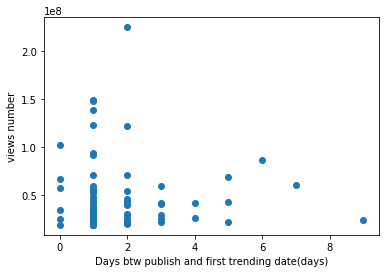

In [32]:
x=df_views_time_lag['time_lag']
y=df_views_time_lag['max(views)']
plt.xlabel("Days btw publish and first trending date(days)")
plt.ylabel("views number")
plt.scatter(x,y)
plt.show()

In [33]:
min_lag=min(df_views_time_lag['time_lag'])
min_lag

0

In [34]:
max_lag=max(df_views_time_lag['time_lag'])
max_lag

9

In [35]:
#Conclusion
#Pouplar movies(views top100)get trending quickly,bascially within 10 days since published.

# Likes vs. Days btw publish and first trending date

In [36]:
df_likes_time_lag=sqldf("SELECT video_id,title,min(trending_date),publish_time,max(likes) FROM vid_data_df group by video_id order by max(likes) DESC limit 100;", locals())
df_likes_time_lag

,video_id,title,min(trending_date),publish_time,max(likes)
0,7C2z4GqqS5E,BTS (방탄소년단) 'FAKE LOVE' Official MV,2018-05-19,2018-05-18,5613827
1,VYOjWnS4cMY,Childish Gambino - This Is America (Official V...,2018-05-08,2018-05-06,5023450
2,ffxKSjUwKdU,Ariana Grande - No Tears Left To Cry,2018-04-21,2018-04-20,3094021
3,FlsCjmMhFmw,YouTube Rewind: The Shape of 2017 | #YouTubeRe...,2017-12-07,2017-12-06,3093544
4,kTlv5_Bs8aw,BTS (방탄소년단) 'MIC Drop (Steve Aoki Remix)' Offi...,2017-11-25,2017-11-24,2729292
...,...,...,...,...,...
95,vn9mMeWcgoM,Jurassic World: Fallen Kingdom - Official Trai...,2017-12-09,2017-12-08,550348
96,d1D1SJ-KqaQ,WINNER - ‘EVERYDAY’ M/V,2018-04-06,2018-04-04,548563
97,9v_rtaye2yY,"Migos, Nicki Minaj, Cardi B - MotorSport (Offi...",2017-12-09,2017-12-08,548457
98,GEB2f5dpFXs,THRIFTING BRANDS!! GOODWILL WITH GREATLIZA.,2017-12-22,2017-12-21,527481


In [37]:
date_format = "%Y-%m-%d"
df_likes_time_lag['min(trending_date)']=df_likes_time_lag['min(trending_date)'].apply(lambda x:dt.datetime.strptime(x, date_format))
df_likes_time_lag['publish_time']=df_likes_time_lag['publish_time'].apply(lambda x:dt.datetime.strptime(x, date_format))
df_likes_time_lag['time_lag']=df_likes_time_lag['min(trending_date)']-df_likes_time_lag['publish_time']
df_likes_time_lag['time_lag']=df_likes_time_lag['time_lag'].apply(lambda x:x.days)
df_likes_time_lag

,video_id,title,min(trending_date),publish_time,max(likes),time_lag
0,7C2z4GqqS5E,BTS (방탄소년단) 'FAKE LOVE' Official MV,2018-05-19,2018-05-18,5613827,1
1,VYOjWnS4cMY,Childish Gambino - This Is America (Official V...,2018-05-08,2018-05-06,5023450,2
2,ffxKSjUwKdU,Ariana Grande - No Tears Left To Cry,2018-04-21,2018-04-20,3094021,1
3,FlsCjmMhFmw,YouTube Rewind: The Shape of 2017 | #YouTubeRe...,2017-12-07,2017-12-06,3093544,1
4,kTlv5_Bs8aw,BTS (방탄소년단) 'MIC Drop (Steve Aoki Remix)' Offi...,2017-11-25,2017-11-24,2729292,1
...,...,...,...,...,...,...
95,vn9mMeWcgoM,Jurassic World: Fallen Kingdom - Official Trai...,2017-12-09,2017-12-08,550348,1
96,d1D1SJ-KqaQ,WINNER - ‘EVERYDAY’ M/V,2018-04-06,2018-04-04,548563,2
97,9v_rtaye2yY,"Migos, Nicki Minaj, Cardi B - MotorSport (Offi...",2017-12-09,2017-12-08,548457,1
98,GEB2f5dpFXs,THRIFTING BRANDS!! GOODWILL WITH GREATLIZA.,2017-12-22,2017-12-21,527481,1


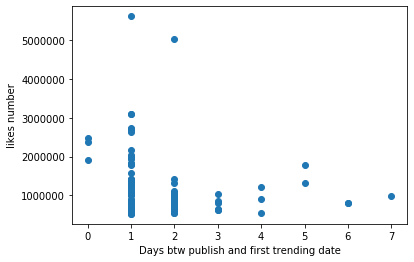

In [38]:
x=df_likes_time_lag['time_lag']
y=df_likes_time_lag['max(likes)']
plt.xlabel("Days btw publish and first trending date")
plt.ylabel("likes number")
plt.scatter(x,y)
plt.show()

In [39]:
min_lag=min(df_likes_time_lag['time_lag'])
min_lag

0

In [40]:
max_lag=max(df_likes_time_lag['time_lag'])
max_lag

7

In [41]:
#Conclusion
#Pouplar movies(likes top100)get trending quickly,bascially within a week since published.

# The trend of views number for popular videos(views top100)

In [42]:
df_views_top100=sqldf("SELECT max(views),video_id, title, category_name FROM vid_data_df group by video_id order by max(views) DESC limit 100;", locals())
vid_id_top100=df_views_top100['video_id']
lst=list(vid_id_top100)

In [43]:
df=sqldf("Select video_id,title,category_name,publish_time,trending_date,views,\
max(views) over(partition by video_id) as max_views,\
min(trending_date) over(partition by video_id) as min_trending_date from vid_data_df order by max_views desc;")
df

,video_id,title,category_name,publish_time,trending_date,views,max_views,min_trending_date
0,VYOjWnS4cMY,Childish Gambino - This Is America (Official V...,Music,2018-05-06,2018-05-08,31648454,225211923,2018-05-08
1,VYOjWnS4cMY,Childish Gambino - This Is America (Official V...,Music,2018-05-06,2018-05-09,47169016,225211923,2018-05-08
2,VYOjWnS4cMY,Childish Gambino - This Is America (Official V...,Music,2018-05-06,2018-05-10,60776509,225211923,2018-05-08
3,VYOjWnS4cMY,Childish Gambino - This Is America (Official V...,Music,2018-05-06,2018-05-11,73432600,225211923,2018-05-08
4,VYOjWnS4cMY,Childish Gambino - This Is America (Official V...,Music,2018-05-06,2018-05-12,85092067,225211923,2018-05-08
...,...,...,...,...,...,...,...,...
40944,-JVITToppE0,Coach Taggart Monday Presser Ahead of Arizona,Sports,2017-11-13,2017-11-16,687,704,2017-11-16
40945,-JVITToppE0,Coach Taggart Monday Presser Ahead of Arizona,Sports,2017-11-13,2017-11-17,704,704,2017-11-16
40946,y6KYFcta4SE,"1 dead, others injured after Ky. school shooting",News & Politics,2018-01-23,2018-01-26,549,559,2018-01-26
40947,y6KYFcta4SE,"1 dead, others injured after Ky. school shooting",News & Politics,2018-01-23,2018-01-27,554,559,2018-01-26


In [44]:
df_top100=df[df['video_id'].isin(lst)]
df_top100

,video_id,title,category_name,publish_time,trending_date,views,max_views,min_trending_date
0,VYOjWnS4cMY,Childish Gambino - This Is America (Official V...,Music,2018-05-06,2018-05-08,31648454,225211923,2018-05-08
1,VYOjWnS4cMY,Childish Gambino - This Is America (Official V...,Music,2018-05-06,2018-05-09,47169016,225211923,2018-05-08
2,VYOjWnS4cMY,Childish Gambino - This Is America (Official V...,Music,2018-05-06,2018-05-10,60776509,225211923,2018-05-08
3,VYOjWnS4cMY,Childish Gambino - This Is America (Official V...,Music,2018-05-06,2018-05-11,73432600,225211923,2018-05-08
4,VYOjWnS4cMY,Childish Gambino - This Is America (Official V...,Music,2018-05-06,2018-05-12,85092067,225211923,2018-05-08
...,...,...,...,...,...,...,...,...
1326,MuPL-PSMX0Q,World's Longest LEGO Walk | Dude Perfect,Sports,2018-03-05,2018-03-14,19412787,19412787,2018-03-06
1327,BQ31l1gPGKM,J. Balvin - Ahora,Music,2018-02-26,2018-02-26,497116,19177871,2018-02-26
1328,BQ31l1gPGKM,J. Balvin - Ahora,Music,2018-02-26,2018-02-27,10633754,19177871,2018-02-26
1329,BQ31l1gPGKM,J. Balvin - Ahora,Music,2018-02-26,2018-02-28,15474680,19177871,2018-02-26


In [45]:
vid_view_top100=sqldf("Select * from df_top100 \
order by max_views desc, trending_date;")
vid_view_top100

,video_id,title,category_name,publish_time,trending_date,views,max_views,min_trending_date
0,VYOjWnS4cMY,Childish Gambino - This Is America (Official V...,Music,2018-05-06,2018-05-08,31648454,225211923,2018-05-08
1,VYOjWnS4cMY,Childish Gambino - This Is America (Official V...,Music,2018-05-06,2018-05-09,47169016,225211923,2018-05-08
2,VYOjWnS4cMY,Childish Gambino - This Is America (Official V...,Music,2018-05-06,2018-05-10,60776509,225211923,2018-05-08
3,VYOjWnS4cMY,Childish Gambino - This Is America (Official V...,Music,2018-05-06,2018-05-11,73432600,225211923,2018-05-08
4,VYOjWnS4cMY,Childish Gambino - This Is America (Official V...,Music,2018-05-06,2018-05-12,85092067,225211923,2018-05-08
...,...,...,...,...,...,...,...,...
1326,MuPL-PSMX0Q,World's Longest LEGO Walk | Dude Perfect,Sports,2018-03-05,2018-03-14,19412787,19412787,2018-03-06
1327,BQ31l1gPGKM,J. Balvin - Ahora,Music,2018-02-26,2018-02-26,497116,19177871,2018-02-26
1328,BQ31l1gPGKM,J. Balvin - Ahora,Music,2018-02-26,2018-02-27,10633754,19177871,2018-02-26
1329,BQ31l1gPGKM,J. Balvin - Ahora,Music,2018-02-26,2018-02-28,15474680,19177871,2018-02-26


In [46]:
date_format = "%Y-%m-%d"
vid_view_top100['trending_date']=vid_view_top100['trending_date'].apply(lambda x:dt.datetime.strptime(x, date_format))
vid_view_top100['min_trending_date']=vid_view_top100['min_trending_date'].apply(lambda x:dt.datetime.strptime(x, date_format))

In [47]:
vid_view_top100['days_after_trending']=(vid_view_top100['trending_date']-vid_view_top100['min_trending_date']).apply(lambda x:x.days)
vid_view_top100.head()

,video_id,title,category_name,publish_time,trending_date,views,max_views,min_trending_date,days_after_trending
0,VYOjWnS4cMY,Childish Gambino - This Is America (Official V...,Music,2018-05-06,2018-05-08,31648454,225211923,2018-05-08,0
1,VYOjWnS4cMY,Childish Gambino - This Is America (Official V...,Music,2018-05-06,2018-05-09,47169016,225211923,2018-05-08,1
2,VYOjWnS4cMY,Childish Gambino - This Is America (Official V...,Music,2018-05-06,2018-05-10,60776509,225211923,2018-05-08,2
3,VYOjWnS4cMY,Childish Gambino - This Is America (Official V...,Music,2018-05-06,2018-05-11,73432600,225211923,2018-05-08,3
4,VYOjWnS4cMY,Childish Gambino - This Is America (Official V...,Music,2018-05-06,2018-05-12,85092067,225211923,2018-05-08,4


Text(0, 0.5, 'views number')

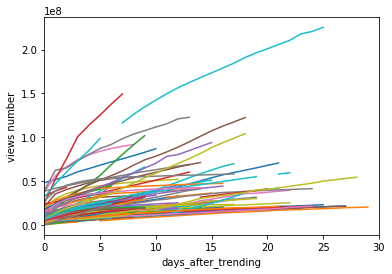

In [48]:
viewtop100_pivot=vid_view_top100.pivot_table('views', index='days_after_trending',columns='video_id').plot(legend=False)
plt.ylabel("views number")

In [49]:
#Conclusion
#The lifespan of trending videos is within 30 days. The views number increse rapidly during
#first 5-10 days and then the increse will slow down.

# 3. word clouds
## example: https://www.geeksforgeeks.org/generating-word-cloud-python/

## input:
### data: all data
### text_column: the column from which we count the words
### weights_columns: assign each row different weights. For example, if weights_columns is ["like"], the words with more likes will be count more times.

In [50]:
def cloud(data,text_column,weight_columns):
    le=data.shape[0]
    wordDict={}
    result=[] # used to store words. 
    for i in range(le):
        words=data[text_column][i]
        n=0
        for column in weight_columns:
            n=n+data[column][i]
        words=str(words).split()
        for word in words:
            # strip punctuations
            word=word.strip(string.punctuation)
            # covert it to lowercase
            word=word.lower()
            # count the number of each word
            wordDict[word] = wordDict.get(word,0)+n
    for key,value in wordDict.items():
        for j in range(value//100000):
            result.append(key)
    # to remove some comman and meaningless words, we import stopwords
    STOPWORDS.add("video")
    STOPWORDS.add("last")
    STOPWORDS.add("super")
    STOPWORDS.add("hd")
    STOPWORDS.add("ft")
    STOPWORDS.add("youtube")
    wordcloud=WordCloud(width = 500,height=500,background_color='white',collocations=False,stopwords = STOPWORDS,min_font_size = 10).generate(" ".join(result))
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()

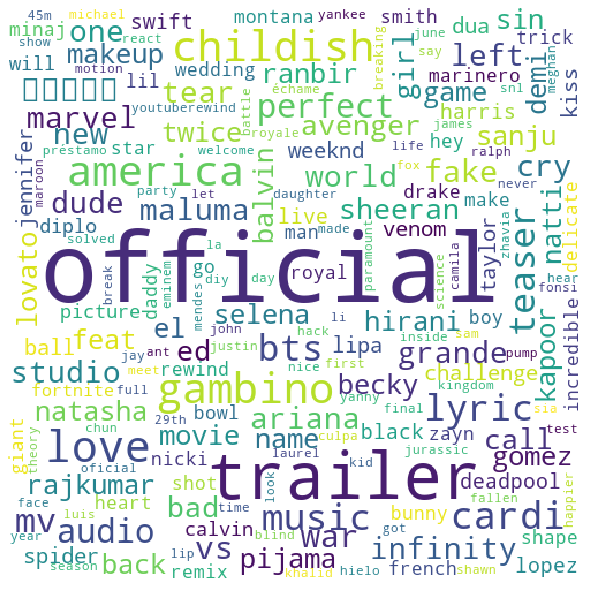

In [51]:
cloud(vid_data_df,"title",["views"])

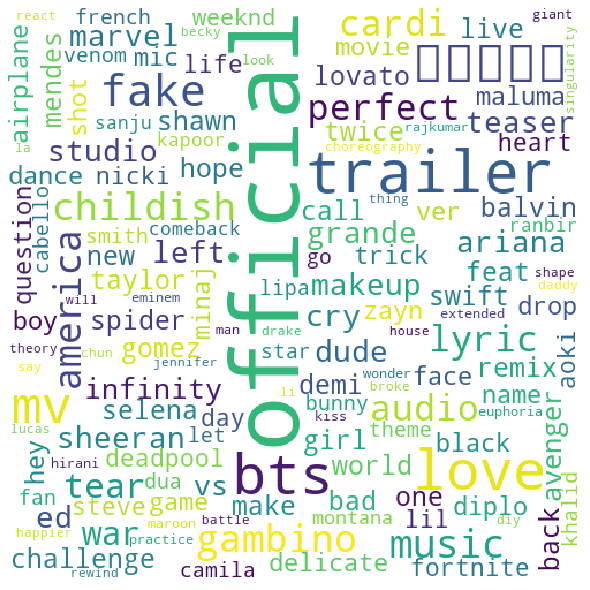

In [52]:
cloud(vid_data_df,"title",["likes"])

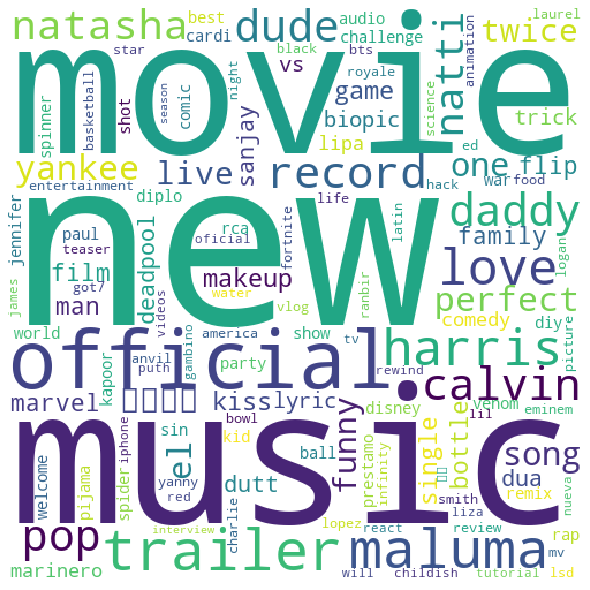

In [53]:
cloud(vid_data_df,"tags",["views"])

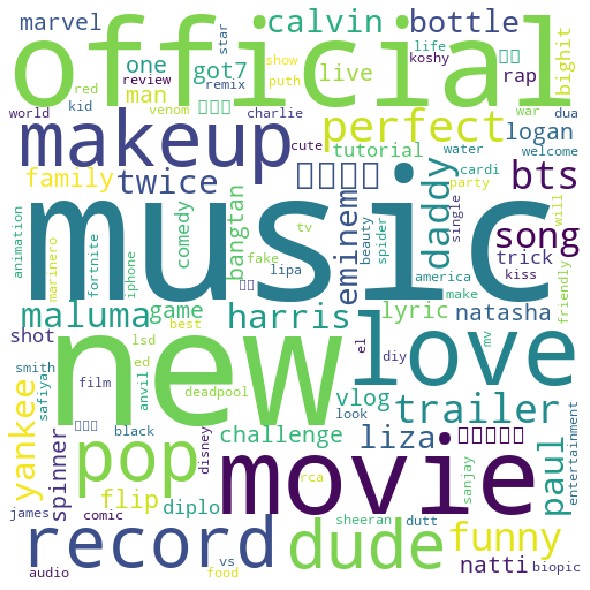

In [54]:
cloud(vid_data_df,"tags",["likes"])

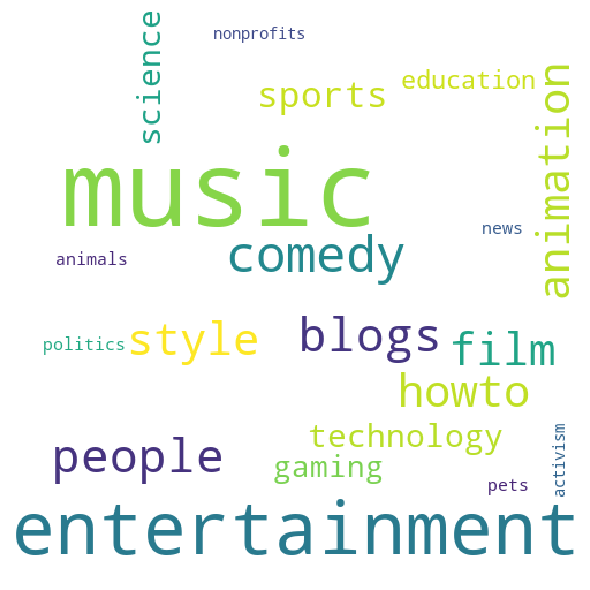

In [55]:
cloud(vid_data_df,"category_name",["likes"])

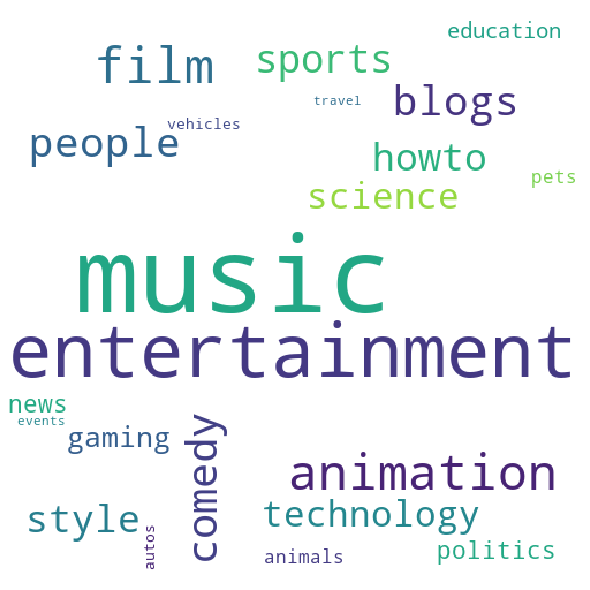

In [56]:
cloud(vid_data_df,"category_name",["views"])